# Bandit Assignment

This assignment should be done in groups of 3 and consists of a number of implementation and theory problems based on the topics discussed in the lectures and the course literature (specifically, **version 5** on arXiv):

[Bandits] *Aleksandrs Slivkins, [Introduction to Multi-Armed Bandits](https://arxiv.org/pdf/1904.07272v5.pdf), Found. Trends Mach. Learn. 12(1-2): 1-286 (2019)*

In the implementation problems **(1, 2, 3 and 5)**, you will implement multi-armed bandit algorithms from the [Bandits] book and use them in a provided multi-armed bandit environment. These problems will be graded based on the correctness of the code.

In the theory problems **(4 and 6)**, you will derive some properties of the algorithms. These problems will be graded based on the correctness of the arguments.

You may use the python libraries imported below (*numpy*, *scipy.stats* and *pandas*).

The assignment should be handed in as an updated notebook. The entire notebook should be run before it is handed in, so that the plots are visible. Ensure that it is completely runnable, in the case that we want to reproduce the results.

## Setup

The cell below contains imports. It may not be modified!

In [1]:
# DO NOT MODIFY
import pandas as pd
import numpy as np
import scipy.stats as st
import matplotlib.pyplot as plt

SEED = 150
ITERATIONS = 10
K = 100
T = 10000

The cell below contains the bandit environment and may not be modified!

In [2]:
# DO NOT MODIFY
class Environment:
    def __init__(self, K=10, seed=0):
        self.random_state = np.random.RandomState(seed=seed)
        self.mu = st.beta.rvs(a=1, b=1, size=K, random_state=self.random_state)

    def expected_value(self, a):
        return self.mu[a]

    def perform_action(self, a):
        return st.bernoulli.rvs(self.mu[a], random_state=self.random_state)

    def optimal_action(self):
        return np.argmax(self.mu)

The cell below contains the bandit algorithm base class and may not be modified!

In [3]:
# DO NOT MODIFY
class BanditAlgorithmBase:
    def select_action(self):
        pass

    def update(self, action, reward):
        pass

The cell below contains the bandit experiment and may not be modified!

In [4]:
# DO NOT MODIFY
class Experiment:
    def __init__(self, environment, bandit_algorithm):
        self.environment = environment
        self.bandit_algorithm = bandit_algorithm

    def run_experiment(self, T=100):
        instant_regrets = np.zeros(T)
        for t in range(0, T):
            action = self.bandit_algorithm.select_action()
            reward = self.environment.perform_action(action)
            self.bandit_algorithm.update(action, reward)

            optimal_action = self.environment.optimal_action()
            instant_regret = self.environment.expected_value(optimal_action) - self.environment.expected_value(action)
            instant_regrets[t] = instant_regret
        cumulative_regrets = np.cumsum(instant_regrets)
        return (instant_regrets, cumulative_regrets)


The cell below contains a function for repeated experiments with a provided bandit algorithm, averaging regret over the runs. It may not be modified!

In [5]:
# DO NOT MODIFY
def run_repeated_experiments(bandit_algorithm_class, seed):
    instant_regrets = []
    cumulative_regrets = []
    for i in range(ITERATIONS):
        bandit_algorithm = bandit_algorithm_class(T, K)
        environment = Environment(K, seed+i+1)
        experiment = Experiment(environment, bandit_algorithm)

        instant_regrets_i, cumulative_regrets_i = experiment.run_experiment(T)
        instant_regrets.append(instant_regrets_i)
        cumulative_regrets.append(cumulative_regrets_i)
    return pd.DataFrame(data={'t': np.arange(1, T+1),
                             'instant_regret': np.mean(np.vstack(np.array(instant_regrets)), axis=0),
                             'regret': np.mean(np.vstack(np.array(cumulative_regrets)), axis=0)})


## Stochastic Bandits (Chapter 1)

### Problem 1
(3 points)

Implement the *Explore-First* algorithm (**Algorithm 1.1** in [Bandits]) within the provided bandit algorithm template below. Use $N = \left(\frac{T}{K}\right)^{2/3} \cdot \left( \log T \right)^{1/3}$.

In [6]:
class ExploreFirst(BanditAlgorithmBase):
    def __init__(self, T, K):
        """
        Constructor of the bandit algorithm

        Parameters
        ----------
        T : int
            Horizon
        K : int
            Number of actions
        """
        self.num_rounds_ran = 0
        self.num_explore_rounds = np.round((T / K)**(2/3) * (np.log(T))**(1/3)) * K
        self.arm_index = 0
        self.rewards = []
        for _ in range(K):
            self.rewards.append([])
        self.best_arm = 0
        self.num_arms = K
        return

    def select_action(self):
        """
        Select an action which will be performed in the environment in the
        current time step

        Returns
        -------
        An action index (integer) in [0, K-1]
        """
        if self.num_rounds_ran < self.num_explore_rounds:
            action = self.arm_index
            self.arm_index = (self.arm_index + 1) %  self.num_arms
        else:
            action = self.best_arm
        return action

    def update(self, action, reward):
        """
        Update the bandit algorithm with the reward received from the
        environment for the action performed in the current time step

        Parameters
        ----------
        action : int
            An action index (integer) in [0, K-1]
        reward : int
            Reward (integer) in {0, 1} (Bernoulli rewards)

        """
        self.rewards[action].append(reward)
        self.num_rounds_ran += 1
        if self.num_rounds_ran < self.num_explore_rounds:
            mean_rewards = np.zeros(self.num_arms)
            for k in range(self.num_arms):
                mean_rewards[k] = np.mean(self.rewards[k])
            self.best_arm= np.argmax(mean_rewards)

Run the algorithm in the provided environment using the code below (averaging regret over 5 runs). The exploration and exploitation phases should be clearly visible in the plot.

/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


<Axes: title={'center': 'Explore First'}, xlabel='t'>

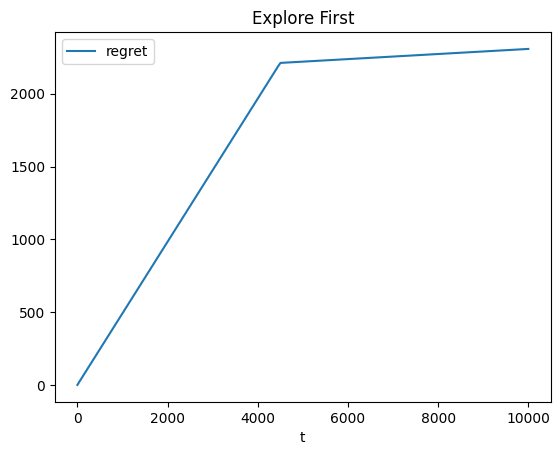

In [17]:
# DO NOT MODIFY
np.random.seed(SEED)
ef_df = run_repeated_experiments(ExploreFirst, SEED)
ef_df.plot(x='t', y='regret', title='Explore First')

### Problem 2
(3 points)

Implement the $ \epsilon_t $-*Greedy* algorithm (**Algorithm 1.2** in [Bandits]) within the provided bandit algorithm template below. Use $\epsilon_t = \min \left\{1,\ t^{-1/3} \cdot (K \log t)^{1/3}\right\} $.

In [8]:
class EpsilonTGreedy(BanditAlgorithmBase):
    def __init__(self, T, K):
        """
        Constructor of the bandit algorithm

        Parameters
        ----------
        T : int
            Horizon
        K : int
            Number of actions
        """

        self.num_rounds_ran = 0
        self.rewards = []
        for _ in range(K):
            self.rewards.append([])
        self.best_arm = 0
        self.num_arms = K
        self.epsilon = 1
        return

    def select_action(self):
        """
        Select an action which will be performed in the environment in the
        current time step

        Returns
        -------
        An action index (integer) in [0, K-1]
        """

        random_num = np.random.uniform()
        if random_num < self.epsilon:
            action = np.random.choice(self.num_arms)
        else:
            action = self.best_arm
        return action

    def update(self, action, reward):
        """
        Update the bandit algorithm with the reward received from the
        environment for the action performed in the current time step

        Parameters
        ----------
        action : int
            An action index (integer) in [0, K-1]
        reward : int
            Reward (integer) in {0, 1} (Bernoulli rewards)

        """

        self.rewards[action].append(reward)
        self.num_rounds_ran += 1
        mean_rewards = np.zeros(self.num_arms)
        for k in range(self.num_arms):
            mean = np.mean(self.rewards[k])
            if np.isnan(mean):
                mean_rewards[k] = 0
            else:
                mean_rewards[k] = mean
        self.best_arm= int(np.argmax(mean_rewards))
        self.epsilon = np.min((1, self.num_rounds_ran**(-1 / 3) * (self.num_arms *  np.log(self.num_rounds_ran))**(1 / 3)))
        return

Run the algorithm in the provided environment using the code below (averaging regret over 5 runs). The plot should show sublinear regret with respect to $t$.

/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


<Axes: title={'center': 'Epsilon_t-Greedy'}, xlabel='t'>

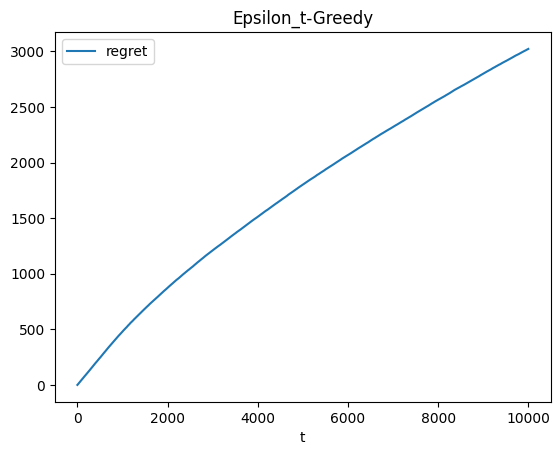

In [9]:
# DO NOT MODIFY
np.random.seed(SEED)
eg_df = run_repeated_experiments(EpsilonTGreedy, SEED)
eg_df.plot(x='t', y='regret', title='Epsilon_t-Greedy')

### Problem 3
(3 points)

Implement the UCB1 algorithm (**Algorithm 1.5** in [Bandits]) within the provided bandit algorithm template below.

In [10]:
class UCB1(BanditAlgorithmBase):
    def __init__(self, T, K):
        """
        Constructor of the bandit algorithm

        Parameters
        ----------
        T : int
            Horizon
        K : int
            Number of actions
        """
        self.num_rounds_ran = 0
        self.arm_index = 0
        self.rewards = []
        for _ in range(K):
            self.rewards.append([])
        self.best_arm = 0
        self.num_arms = K
        self.epsilon = 1
        self.num_rounds_per_arm = np.zeros(K)
        self.mean_plus_ub = np.zeros(K)
        return

    def select_action(self):
        """
        Select an action which will be performed in the environment in the
        current time step

        Returns
        -------
        An action index (integer) in [0, K-1]
        """
        if self.num_rounds_ran < 100:
            self.num_rounds_per_arm[self.arm_index] += 1
            return self.arm_index
        else:
            best_arm = np.argmax(self.mean_plus_ub)
            self.num_rounds_per_arm[best_arm] += 1
            return best_arm

    def update(self, action, reward):
        """
        Update the bandit algorithm with the reward received from the
        environment for the action performed in the current time step

        Parameters
        ----------
        action : int
            An action index (integer) in [0, K-1]
        reward : int
            Reward (integer) in {0, 1} (Bernoulli rewards)

        """
        self.num_rounds_ran += 1
        if self.num_rounds_ran < 100:
            self.arm_index += 1
        self.rewards[action].append(reward)
        self.mean_plus_ub[action] = np.mean(self.rewards[action]) + np.sqrt(2 * np.log(self.num_rounds_ran) / self.num_rounds_per_arm[action])


Run the algorithm in the provided environment using the code below (averaging regret over 5 runs). The plot should show sublinear regret with respect to $t$.

<Axes: title={'center': 'UCB1'}, xlabel='t'>

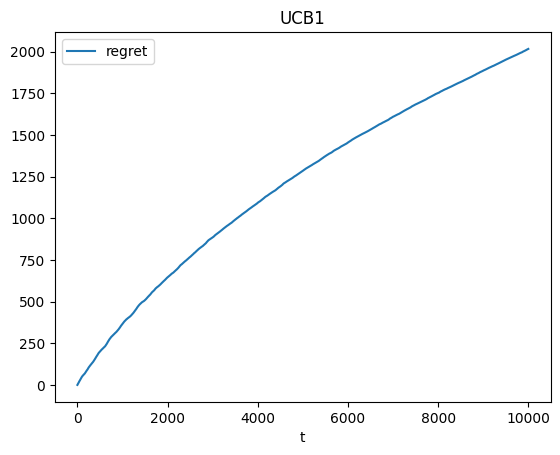

In [11]:
# DO NOT MODIFY
np.random.seed(SEED)
ucb1_df = run_repeated_experiments(UCB1, SEED)
ucb1_df.plot(x='t', y='regret', title='UCB1')

### Problem 4
(6 points)

This theory problem is based on **Exercise 1.1** in [Bandits]. The proofs in **Chapter 1** consider environments where the rewards are in the interval $[0,1]$. Consider the case when we have additional knowledge about about the problem and that we know that the rewards for each action are in the interval $\left[\frac{1}{2}, \frac{1}{2} + \epsilon\right]$ for some fixed $\epsilon \in \left(0, \frac{1}{2}\right)$.

Consider a version of $\text{UCB1}$ modified to utilize this knowledge (you do not need to specify the algorithm completely, just define the new confidence radius $r_t(a)$). For this algorithm and problem setting, prove that:

$\mathbb{E}\left[R(t)\right] \leq \frac{2 \epsilon t}{T^2} + 2 \epsilon \sqrt{2 K t \log T}$

**Instructions:** Use a version of Hoeffding Inequality with ranges (**Theorem A.2** in the [Bandits] book) to modify the confidence radius $r_t(a)$. Subsequently follow the steps of the analysis leading up to **Theorem 1.14** in [Bandits] to derive the regret bound, though show the actual constants instead of using big O notation:

1. Define the clean event, like in **Section 1.3.1**, and lower bound the probability of the event.
2. Start with the definition of the regret $\mathbb{E}\left[R(t)\right]$, and perform a regret decomposition like on **Page 11** of **Section 1.3.2**.
3. Bound the *gap* $\Delta (a_t)$, like in **Section 1.3.3**.
4. Complete the proof using the technique on **Page 12** of **Section 1.3.2**. Note that applying the bound in step 3 requires careful motivation.

*Write the solution in the Markdown cell below (use LaTeX-math mode for equations, etc.).*

#### Solution

${
\Pr\left( \left| x_n - \mu_n \right| \leq \sqrt{\frac{\alpha \beta \log T}{n}} \right) \geq 1 - 2T^{-2 \alpha}
}$

where $\alpha = 2$

$\beta= \frac{1}{n} \sum_{i \in [n]} (b_i - a_i)^2$

Substituing $a=\frac{1}{2}$ and $b= \epsilon+\frac{1}{2} $ in $\beta = \frac{1}{n} \sum_{i \in [n]} \epsilon^2$

Defining clean event:

${
\Pr\left( \left| \mu_t(a) - \mu(a) \right| \leq \sqrt{\frac{2 \epsilon^2 \log T}{n}} \right) \geq 1 - \frac{2}{T^4}
}$

Total Expectation of regrets:   

${
\mathbb{E}[R(t)] = \mathbb{E}[R(t) | \text{clean}] \cdot \Pr[\text{clean}] + \mathbb{E}[R(t) | \text{dirty}] \cdot \Pr[\text{dirty}]
}$



${
=  \mathbb{E}[R(t) | \text{clean}] + ϵ t \frac{2}{T^2}
}$


${
    Δ(a_t) = 2 ϵ \sqrt {\frac{2 log T} {n_t(a)}}
}$

${
    R(t,a) = n_t(a) \delta_t = 2 \sqrt{log T n_t (a)}
}$


${
    \mathbb{E}[R(t) | \text{clean}] = 2 ϵ \sqrt{2 \log T} \sum _{a \in A^{+}} \sqrt{n_t(a)}
}$

${
    =2 ϵ \sqrt{2 log T} k (\frac {1}{k} \sum \sqrt{n_t (a)})
}$

${
 ≤ 2 ϵ \sqrt {2 log T} k \sqrt{\frac {1}{k} \sum n_t(a)}
}$

${
    \leq 2 ϵ \sqrt{2 log T} k \sqrt{\frac{t}{k}}
}$

${
    \leq 2 ϵ t\sqrt{2 k \log T}
}$


${
\mathbb{E}[R(t)] \leq 2 ϵ t\sqrt{2 k \log T} + ϵ t \frac{2}{T^2}
}$



## Bayesian Bandits (Chapter 3)

### Problem 5
(3 points)

Implement the *Thompson Sampling* algorithm (**Algorithm 3.3** in [Bandits]) within the provided bandit algorithm template below. Assume independent priors and that the prior is $\mathbb{P} = \text{Beta}(\alpha_0, \beta_0)$ with $\alpha_0 = 1$ and $\beta_0 = 1$ (i.e. the **Beta-Bernoulli** setting, on **page 35** in [Bandits]).

**Note:** There is a typo in the expression for the posterior $\mathbb{P}_H$ in [Bandits]. It should be $\text{Beta}(\alpha_0 + \text{REW}_H,\ \beta_0 + t - \text{REW}_H)$.

In [12]:
class ThompsonSampling(BanditAlgorithmBase):
    def __init__(self, T, K):
        """
        Constructor of the bandit algorithm

        Parameters
        ----------
        T : int
            Horizon
        K : int
            Number of actions
        """

        self.parameters = np.ones((K, 2))
        self.num_arms = K


    def select_action(self):
        """
        Select an action which will be performed in the environment in the
        current time step

        Returns
        -------
        An action index (integer) in [0, K-1]
        """
        samples = np.zeros(self.num_arms)
        for k in range(self.num_arms):
            samples[k] = np.random.beta(self.parameters[k, 0], self.parameters[k, 1])
        return np.argmax(samples)

    def update(self, action, reward):
        """
        Update the bandit algorithm with the reward received from the
        environment for the action performed in the current time step

        Parameters
        ----------
        action : int
            An action index (integer) in [0, K-1]
        reward : int
            Reward (integer) in {0, 1} (Bernoulli rewards)

        """
        self.parameters[action, 0] += reward
        self.parameters[action, 1] += 1 - reward


Run the algorithm in the provided environment using the code below (averaging regret over 5 runs). The plot should show sublinear regret with respect to $t$.

<Axes: title={'center': 'Thompson Sampling'}, xlabel='t'>

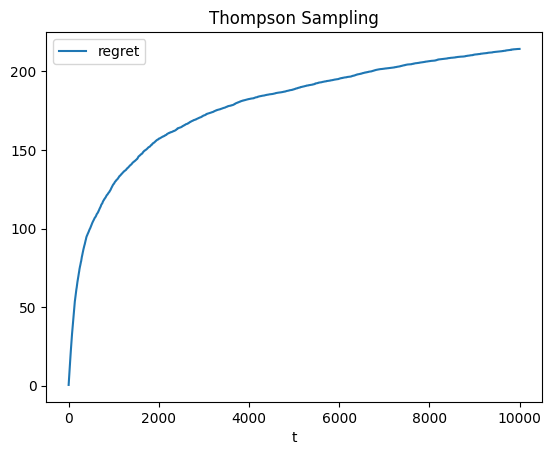

In [13]:
# DO NOT MODIFY
np.random.seed(SEED)
ts_df = run_repeated_experiments(ThompsonSampling, SEED)
ts_df.plot(x='t', y='regret', title='Thompson Sampling')

### Problem 6
(6 points)

In this theory problem, you will show an intermediary step in the proof for the Bayesian regret bound of *Thompson Sampling* in the [Bandits] book.

You are given a $K$-armed bandit problem with rewards in the interval $[0, 1]$. You can assume that $K \leq T$, where $T$ is the horizon. Additionally, you can assume that **Lemma 1.5** holds (i.e., for this assignment we define $r_t (a) := \sqrt{\frac{2  \log T}{ n_t (a)}}$, and then it holds that $\text{Pr}\left\{ \mathcal{E} \right\} \geq 1 - \frac{2}{T^2}$ with $\mathcal{E} := \left\{ \forall a \forall t \;\; \vert \bar{\mu}_t (a) - \mu (a) \vert \leq r_t (a) \right\}$). Then, with $\text{UCB}_t (a) := \bar{\mu}_t (a) + r_t (a)$, show that $\mathbb{E}\left[ \left[ \text{UCB}_t (a) - \mu (a) \right]^{-} \right] \leq \frac{2}{TK}$ (i.e., show that Equation 3.14 in [Bandits], with $\gamma = 2$, holds for all arms $a$ and rounds $t$).

**Note:** $[x]^{-}$ is the negative portion of $x$, i.e., $[x]^{-} = 0$ if $x \geq 0$ and $[x]^{-} = \vert x \vert$ otherwise.

**Hint:** Remember that, given a random variable $X$, an event $\mathcal{E}$ (subset of the sample space) and its complement $\mathcal{E}^c$, by the tower rule,   

*Write the solution in the Markdown cell below (use LaTeX-math mode for equations, etc.).*

#### Solution

$$
\Pr\left(  \forall a \, \forall t \;\; \left| \bar{\mu}_t (a) - \mu (a) \right| \leq r_t (a) \right) \geq 1 - \frac{2}{T^2}
$$
$$r_t (a) = \sqrt{\frac{2  \log T}{ n_t (a)}}$$

$$
\Pr\left( \forall a \, \forall t \;\; \left| \bar{\mu}_t (a) - \mu (a) \right| \leq \sqrt{\frac{2  \log T}{ n_t (a)}} \right) \geq 1 - \frac{2}{T^2}
$$
Tower rule:
Let x be $[ \text{UCB}_t (a) - \mu (a)]^-$

$$
\mathbb{E}[x] = \mathbb{E}[x|ϵ] * Pr(ϵ) + \mathbb{E}[x|ϵ^c]*Pr(ϵ^c)
$$

**Case 1: $ϵ$ holds**
$$
Pr(ϵ) \geq 1- \frac{2}{T^2}
$$
In this case $\text{UCB}_t (a) \geq \mu (a)$ so negative part is equal to zero.
$$
\mathbb{E}[(\text{UCB}_t (a) - \mu (a)]^{-})|ϵ] = 0
$$

**Case 2: $ϵ$ does not hold**

The confidence interval does not holds the true mean. $\text{UCB}_t (a) \leq \mu (a)$.

In worst case, lets assume error is atmost 1 since the reward distribution is between 0 to 1.
$$
\mathbb{E}[(\text{UCB}_t (a) - \mu (a)]^{-})|ϵ^c] \leq 1
$$


<!-- Substitute $n_t(a)= \frac{T}{K} $ in $r_t(a)$  -->
<!-- $$r_t (a) = \sqrt{\frac{2 K \log T}{ T}}$$   -->


<!-- \mathbb{E}[(\text{UCB}_t (a) - \mu (a)]^{-})|ϵ^c]  \leq \sqrt{\frac{2 K \log T}{ T}} -->


$$
\mathbb{E}[x]= \mathbb{E}[(\text{UCB}_t (a) - \mu (a)]^{-})|ϵ^c]  * Pr(ϵ^c)
$$

$$
\mathbb{E}[x] \leq 1 * \frac{2}{T^2}
$$
Since $ K< N$, $\frac{1}{K} > \frac{1}{N}$
$$
\mathbb{E}[x] \leq  \frac{2}{T *K}
$$

$$\mathbb{E}\left[ \left[ \text{UCB}_t (a) - \mu (a) \right]^{-} \right] \leq \frac{2}{TK}$$

## Final comparison

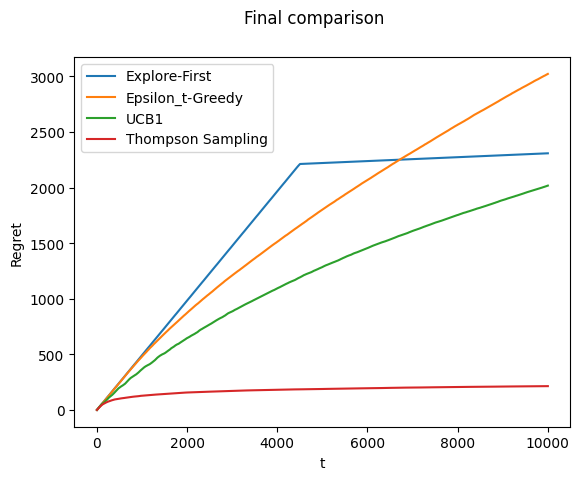

In [18]:
fig, ax = plt.subplots(1,1)
fig.suptitle("Final comparison")
ax.set_xlabel("t"); ax.set_ylabel("Regret")
dfs = [(ef_df, "Explore-First"), (eg_df, "Epsilon_t-Greedy"), (ucb1_df, "UCB1"), (ts_df, "Thompson Sampling")]
# dfs = [(eg_df, "Epsilon_t-Greedy"), (ucb1_df, "UCB1"), (ts_df, "Thompson Sampling")]

for df, label in dfs: df.plot(x='t', y='regret',ax = ax, label = label)

## Bonus: KL-UCB

(0 points)

As we explored in Problem 4, UCB1 relies on Hoeffding's inequality to determine the confidence radius. Hoeffding's inequality assumes that the reward is bounded (or more generally that they are sub-Gaussian). However, in this assignment we know that the rewards are Bernoulli distributed. As such, Hoeffding's inequality is too general to ensure optimal performance.

KL-UCB is an upper confidence algorithm that uses the following selection rule (after sampling every arm once):
$$
a_t = \argmax_{a} \max_{\tilde{\mu}} \Big\{ \tilde \mu \in [0,1] : d(\bar{\mu}_t(a), \tilde \mu) \leq \frac{\log f(t)}{n_{t}(a)} \Big\}
$$
where $f(t) = 1 + t \log^2(t)$ and $d(p, q) = p \log \frac{p}{q} + (1-p) \log \frac{1-p}{1-q}$ is the KL-divergence between two Bernoulli distributions with mean $p \in (0,1)$ and $q \in (0,1)$. Note that $d(p,q)$ is undefined for $p$ or $q$ in $\{0,1\}$.

As a bonus exercise, implement KL-UCB and compare its performance against UCB1. Since KL-UCB relies on tighter concentration inequalities, we would expect KL-UCB to accumulate less regret than UCB1.

If you are up for it, try making your implementation computationally efficient.

In [19]:
class KLUCB(BanditAlgorithmBase):
    def __init__(self, T, K):
        """
        Constructor of the bandit algorithm

        Parameters
        ----------
        T : int
            Horizon
        K : int
            Number of actions
        """

        # FILL IN CODE HERE
        pass

    def select_action(self):
        """
        Select an action which will be performed in the environment in the
        current time step

        Returns
        -------
        An action index (integer) in [0, K-1]
        """

        # FILL IN CODE HERE
        pass

    def update(self, action, reward):
        """
        Update the bandit algorithm with the reward received from the
        environment for the action performed in the current time step

        Parameters
        ----------
        action : int
            An action index (integer) in [0, K-1]
        reward : int
            Reward (integer) in {0, 1} (Bernoulli rewards)

        """

        # FILL IN CODE HERE
        pass

In [ ]:
# DO NOT MODIFY
np.random.seed(SEED)
klucb_df = run_repeated_experiments(KLUCB, SEED)
klucb_df.plot(x='t', y='regret', title='KL-UCB')

In [ ]:
fig, ax = plt.subplots(1,1)
fig.suptitle("Final comparison")
ax.set_xlabel("t"); ax.set_ylabel("Regret")
dfs = [(ef_df, "Explore-First"), (eg_df, "Epsilon_t-Greedy"), (ucb1_df, "UCB1"), (ts_df, "Thompson Sampling"), (klucb_df, "KL-UCB")]
for df, label in dfs: df.plot(x='t', y='regret',ax = ax, label = label)